In [ ]:
# Importing Libraries
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os

In [ ]:
# Getting Dataset from Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Getting Data Ready

import zipfile
import os
import shutil

zip_file_path = '/content/drive/MyDrive/dataset.zip'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("File extracted successfully!")
else:
    print(f"Error: File not found at {zip_file_path}")

File extracted successfully!


In [ ]:
# Transforms for Train and Val

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# Verificar o conteúdo da pasta dataset
print("Conteúdo de /content/dataset:", os.listdir('/content/dataset'))
# Verificar o conteúdo da pasta dataset/dataset se existir
if 'dataset' in os.listdir('/content/dataset'):
    print("Conteúdo de /content/dataset/dataset:", os.listdir('/content/dataset/dataset'))


Conteúdo de /content/dataset: ['__MACOSX', 'dataset']
Conteúdo de /content/dataset/dataset: ['train', '.DS_Store', 'val']


In [ ]:
# Loading Data
data_dir = '/content/dataset/dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Classes encontradas:", class_names)

Classes encontradas: ['Fermentados', 'Germinados', 'MEI', 'Mancha Parda', 'Mancha Pu╠ürpura', 'Mofados', 'Partidos', 'Picados por Insetos', 'Queimados', 'Sadios', 'Va╠ürios Defeitos']


In [ ]:
# Defining Model
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [ ]:
# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# Training the Model
num_epochs = 25
best_val_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    epoch_loss = {'train': 0.0, 'val': 0.0}
    epoch_acc = {'train': 0.0, 'val': 0.0}

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss[phase] = running_loss / dataset_sizes[phase]
        epoch_acc[phase] = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss[phase]:.4f} Acc: {epoch_acc[phase]:.4f}')

    if epoch_loss['val'] < best_val_loss:
        best_val_loss = epoch_loss['val']
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping triggered")
            break

print('Treinamento completo!')


Epoch 0/24
----------
train Loss: 0.4888 Acc: 0.8148
val Loss: 1.4095 Acc: 0.6304
Epoch 1/24
----------
train Loss: 0.7935 Acc: 0.8086
val Loss: 1.2421 Acc: 0.6957
Epoch 2/24
----------
train Loss: 0.4601 Acc: 0.8210
val Loss: 0.8726 Acc: 0.7609
Epoch 3/24
----------
train Loss: 0.4703 Acc: 0.8395
val Loss: 0.9288 Acc: 0.7391
Epoch 4/24
----------
train Loss: 0.5167 Acc: 0.8519
val Loss: 1.2215 Acc: 0.6957
Epoch 5/24
----------
train Loss: 0.4911 Acc: 0.8333
val Loss: 1.1468 Acc: 0.6957
Epoch 6/24
----------
train Loss: 0.4351 Acc: 0.8395
val Loss: 1.1940 Acc: 0.7174
Epoch 7/24
----------
train Loss: 0.4418 Acc: 0.8457
val Loss: 0.9074 Acc: 0.7174
Early stopping triggered
Treinamento completo!


In [ ]:
# Saving the Model
torch.save(model.state_dict(), '/content/drive/MyDrive/model.pth')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [ ]:
# Testing

import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))
model = model.to(device)
model.eval()

from PIL import Image

def classify_image(image_path, model, transform):
    # Abrir e transformar a imagem
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)

    # Fazer a previsão
    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        predicted_class = class_names[preds[0]]

    return predicted_class

prediction_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_path = '/content/drive/MyDrive/new_image.jpg'

predicted_class = classify_image(image_path, model, prediction_transform)
print(f'A imagem é classificada como: {predicted_class}')


<ipython-input-34-1d42342a0437>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/model.pth'))


A imagem é classificada como: MEI


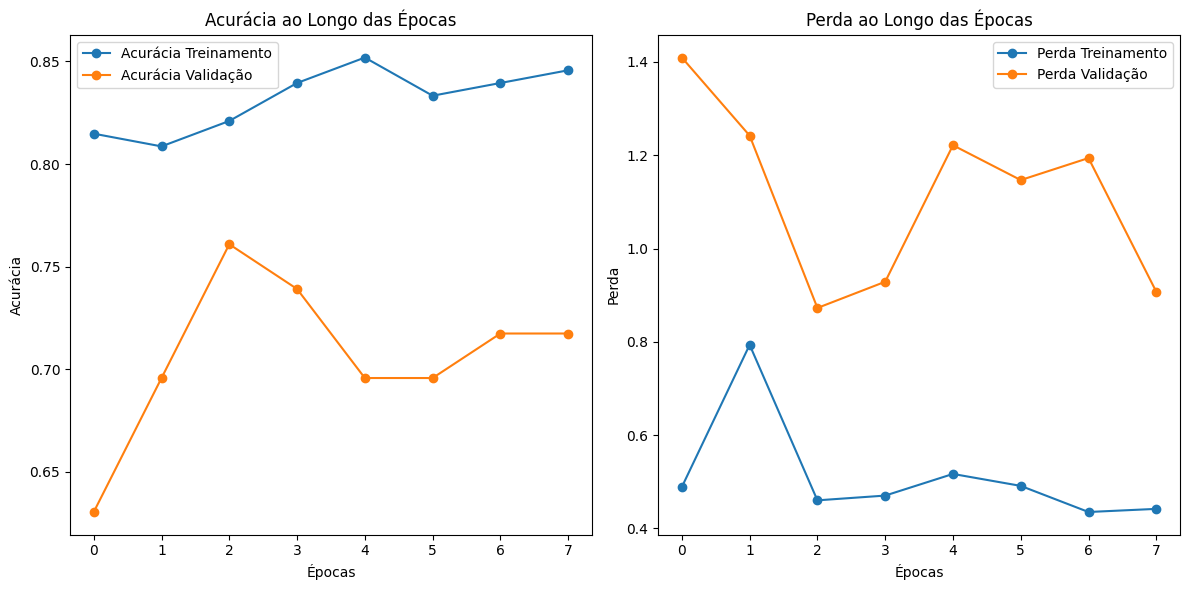

In [ ]:
# Generating Accuracy and Loss Graphs
import matplotlib.pyplot as plt

epocas = list(range(8))
acuracia_train = [0.8148, 0.8086, 0.8210, 0.8395, 0.8519, 0.8333, 0.8395, 0.8457]
acuracia_val = [0.6304, 0.6957, 0.7609, 0.7391, 0.6957, 0.6957, 0.7174, 0.7174]
perda_train = [0.4888, 0.7935, 0.4601, 0.4703, 0.5167, 0.4911, 0.4351, 0.4418]
perda_val = [1.4095, 1.2421, 0.8726, 0.9288, 1.2215, 1.1468, 1.1940, 0.9074]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(epocas, acuracia_train, label='Acurácia Treinamento', marker='o')
ax1.plot(epocas, acuracia_val, label='Acurácia Validação', marker='o')
ax1.set_title('Acurácia ao Longo das Épocas')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Acurácia')
ax1.legend()

ax2.plot(epocas, perda_train, label='Perda Treinamento', marker='o')
ax2.plot(epocas, perda_val, label='Perda Validação', marker='o')
ax2.set_title('Perda ao Longo das Épocas')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Perda')
ax2.legend()

plt.tight_layout()
plt.show()